# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

[3. XGBoost](#3.-XGBoost)

[4. Random Forest](#4.-Random-Forest)

---

In [1]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)
seed=123

In [2]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "xgboost", "Matrix", "Ckmeans.1d.dp", 
                     "randomForest", "caretEnsemble", "MASS", "DMwR", "ROSE", "plyr")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

In [3]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")
library("caretEnsemble")
library("MASS")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")
library("randomForest")
library("DMwR")
library("ROSE")
library("plyr")


Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Warning message:
"package 'ROCR' was built under R version 3.3.2"Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.3.2"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loading required package: lattice
Warning message:
"package 'caretEnsemble' was built under R version 3.3.2"
Attaching package: 'caretEnsemble'

The following object is masked from 'package:ggplot2':

    autoplot

Warning message:
"package 'xgboost' was built under R version 3.3.2"Warning message:
"package 'Ckmeans.1d.dp' was built under R version 3.3.2"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:psych':

    outlier

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'DMwR' wa

In [209]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [5]:
prostate <- read.csv("./prostate.csv")

In [6]:
# Before we do anything, dedicate 20% of our data to an unseen Test set.

# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

set.seed(seed)
train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [7]:
# Check the head of the dataframe
head(train)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
863,863,5,8,10,9,2,2,8,6,2,3,0
2365,2365,4,4,2,4,4,1,3,7,3,9,0
1227,1227,7,4,9,2,4,2,3,9,9,8,0
2647,2647,5,5,7,2,4,1,8,10,1,7,3
2818,2818,10,1,2,5,7,2,8,5,9,5,1
137,137,8,1,2,10,10,2,2,3,1,5,0


In [8]:
# Check structure of the datatypes
str(train)

'data.frame':	2400 obs. of  12 variables:
 $ ID    : int  863 2365 1227 2647 2818 137 1582 2672 1650 1366 ...
 $ ATT1  : int  5 4 7 5 10 8 7 2 2 5 ...
 $ ATT2  : int  8 4 4 5 1 1 1 10 1 4 ...
 $ ATT3  : int  10 2 9 7 2 2 5 5 6 10 ...
 $ ATT4  : int  9 4 2 2 5 10 4 8 2 7 ...
 $ ATT5  : int  2 4 4 4 7 10 8 5 8 10 ...
 $ ATT6  : int  2 1 2 1 2 2 1 4 2 10 ...
 $ ATT7  : int  8 3 3 8 8 2 9 2 3 3 ...
 $ ATT8  : int  6 7 9 10 5 3 2 6 4 8 ...
 $ ATT9  : int  2 3 9 1 9 1 6 1 1 10 ...
 $ ATT10 : int  3 9 8 7 5 5 7 3 4 2 ...
 $ Result: int  0 0 0 3 1 0 0 2 2 1 ...


We can drop the ID column as it adds no benefit to our modelling

In [9]:
train$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [10]:
train$Result <- as.factor(train$Result) 

In [11]:
# Let's check for incomplete observations
nrow(train[complete.cases(train),])

[1] 2400

In [12]:
# Check the proportions of each factor within the Result variable in our train set
print(table(train$Result))


  0   1   2   3 
868 876 495 161 


In [13]:
# Check the proportions of each factor within the Result variable in our test set
print(table(test$Result))


  0   1   2   3 
214 204 147  35 


We have class imbalance. This will need to be addressed when training our models, potentially with some sampling techniques. 

In [14]:
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,2400.000,5.835,2.651,6.000,5.793,2.965,2.000,10.000,8.000,0.098,-1.160,0.054
ATT2,2.000,2400.000,4.510,2.736,4.000,4.327,2.965,1.000,10.000,9.000,0.401,-0.972,0.056
ATT3,3.000,2400.000,5.865,2.675,6.000,5.831,2.965,2.000,10.000,8.000,0.090,-1.189,0.055
ATT4,4.000,2400.000,5.807,2.630,6.000,5.759,2.965,2.000,10.000,8.000,0.090,-1.154,0.054
ATT5,5.000,2400.000,5.767,2.631,6.000,5.708,2.965,2.000,10.000,8.000,0.111,-1.144,0.054
ATT6,6.000,2400.000,4.450,2.699,4.000,4.264,2.965,1.000,10.000,9.000,0.433,-0.947,0.055
ATT7,7.000,2400.000,4.474,2.739,4.000,4.290,2.965,1.000,10.000,9.000,0.399,-1.026,0.056
ATT8,8.000,2400.000,4.499,2.729,4.000,4.317,2.965,1.000,10.000,9.000,0.386,-0.978,0.056
ATT9,9.000,2400.000,4.484,2.688,4.000,4.299,2.965,1.000,10.000,9.000,0.412,-0.918,0.055
ATT10,10.000,2400.000,4.451,2.689,4.000,4.263,2.965,1.000,10.000,9.000,0.412,-0.935,0.055


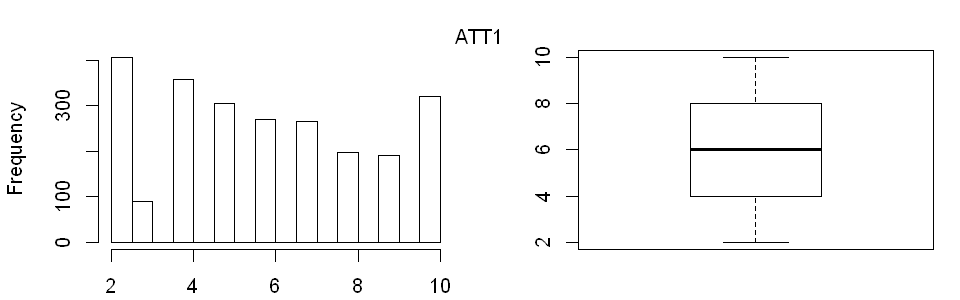

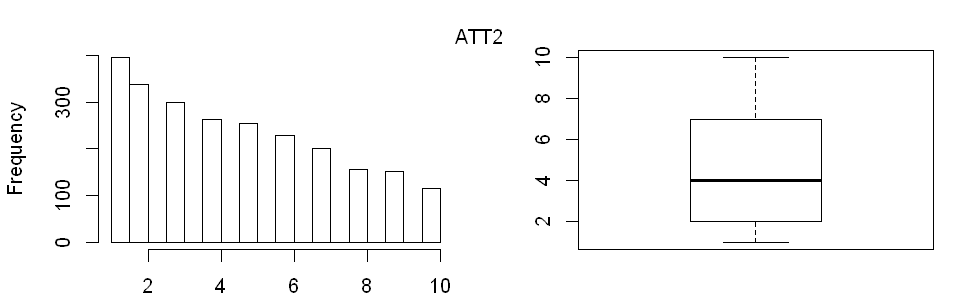

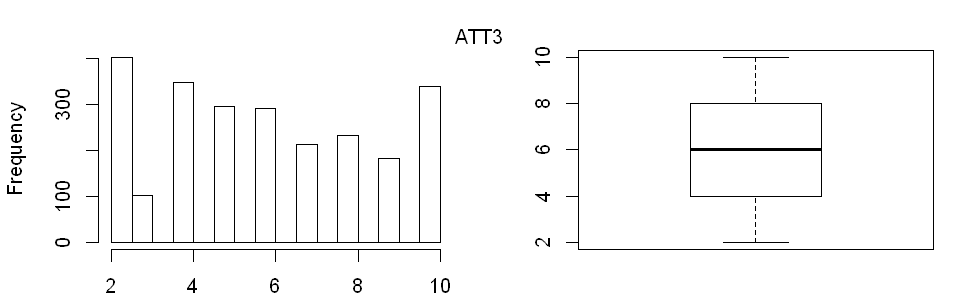

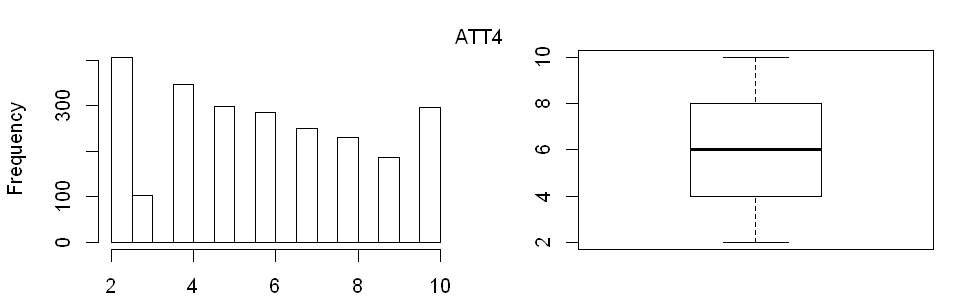

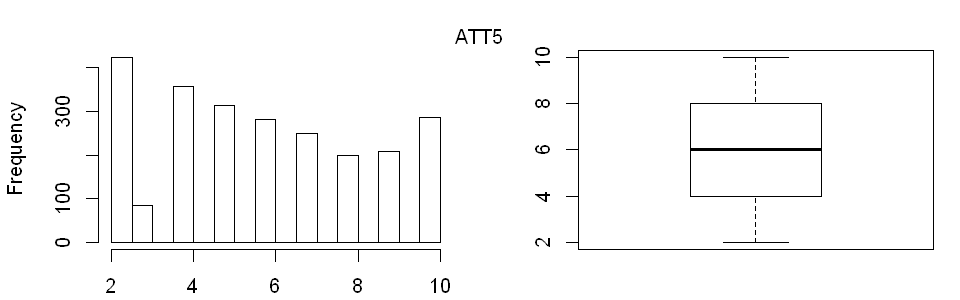

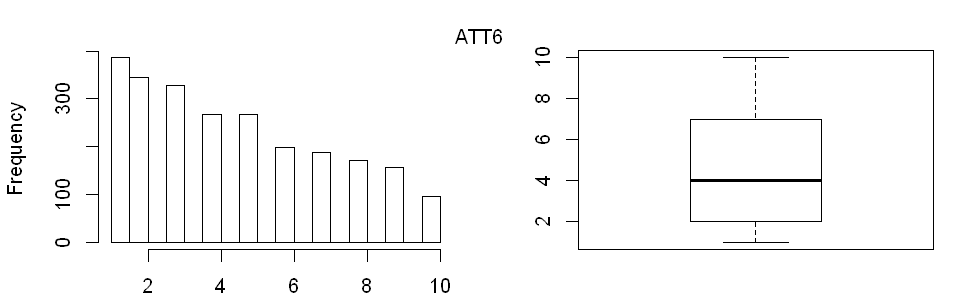

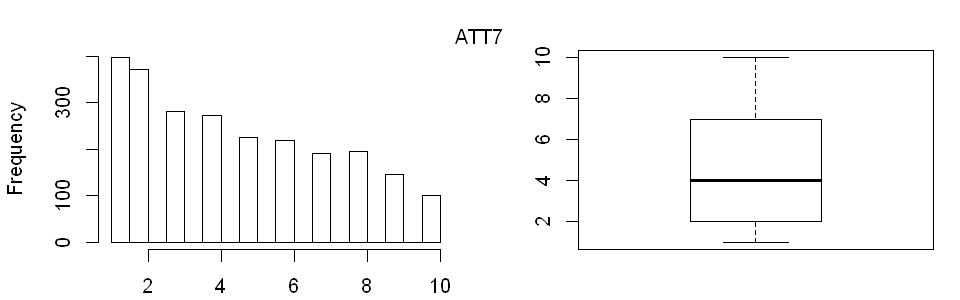

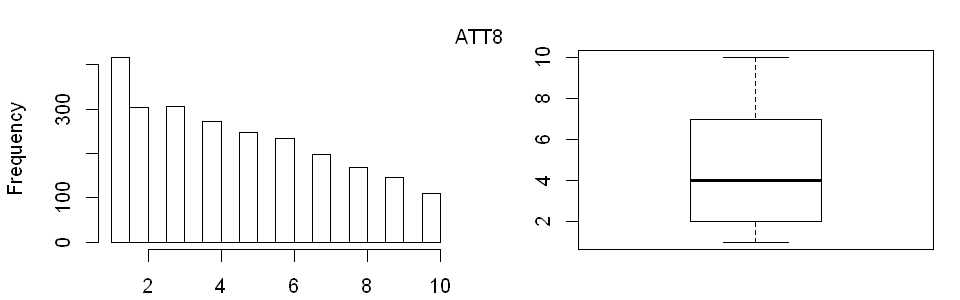

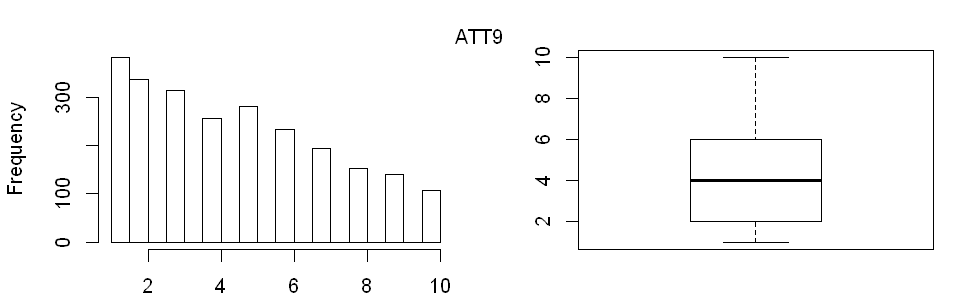

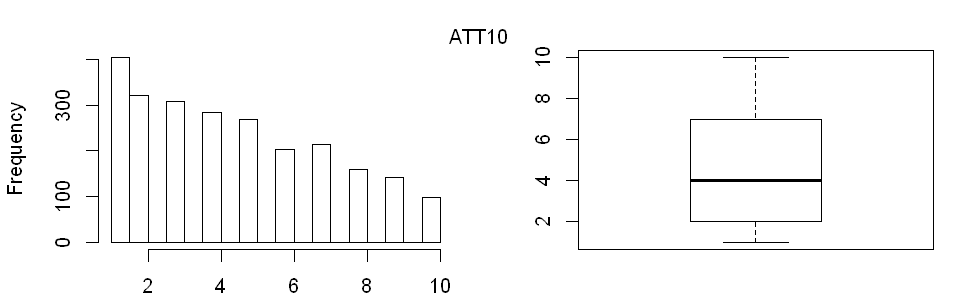

In [15]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(train)) {
    if (i != "Result") {
        hist(train[[i]],xlab=NULL,main=NULL)
        boxplot(train[[i]])
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

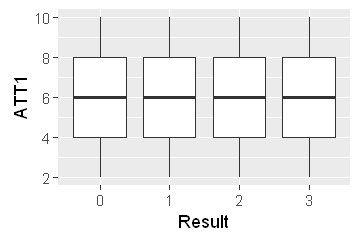

In [16]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(train, aes(x = Result, y = ATT1)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT2)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT3)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT4)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT5)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT6)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT7)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT8)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT9)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

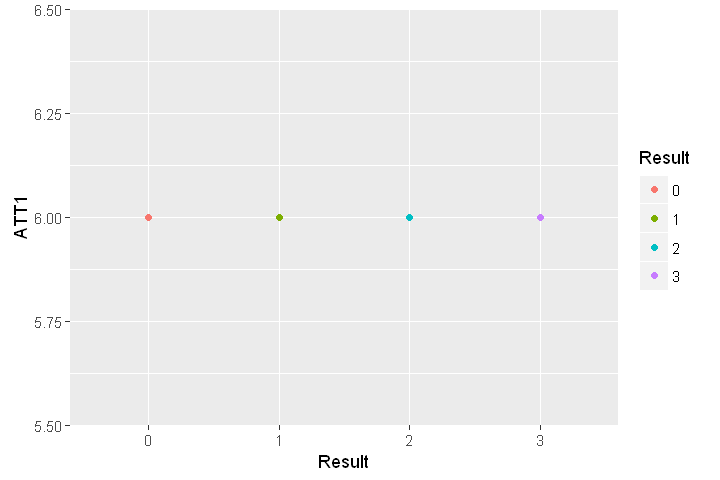

In [17]:
ggplot(aes(x=Result, y=ATT1, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=train) + geom_point(stat='summary', fun.y=median)

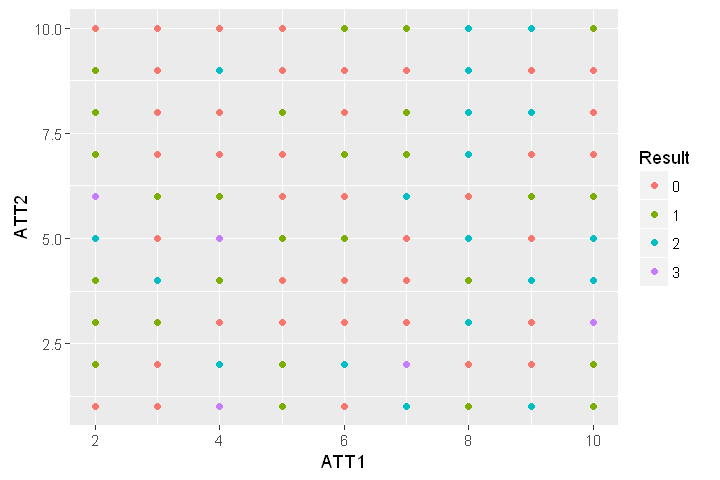

In [18]:
qplot(ATT1, ATT2, colour=Result, data=train)

# 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

---
# 3. XGBoost

In [80]:
# perform down sampling to obtain even amount of classes
#xg_train <- Udf.Utilities.DownSample(train)
xg_train <- Udf.Utilities.UpSample(train)
#xg_train <- Udf.Utilities.SmoteSample(train)

xg_test <- test

In [81]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w


  0   1   2   3 
876 876 876 876 

In [82]:
# store the actuals for future comparison
actual <- test$Result

In [83]:
# set the Result to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [84]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [85]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [86]:
watchlist <- list(xg_train=dtrain)

In [87]:
# cross validate to select optimal value for number of rounds
set.seed(seed)
n_rounds.cv <- 500
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 6, eta = 0.1,
               colsample_bytree = 0.9, subsample = 0.9)

bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.508879+0.012468	test-merror:0.624680+0.024307
[20]	train-merror:0.176560+0.008523	test-merror:0.468025+0.029982
[40]	train-merror:0.100583+0.002541	test-merror:0.418943+0.031163
[60]	train-merror:0.061802+0.002610	test-merror:0.406106+0.027163
[80]	train-merror:0.036307+0.002331	test-merror:0.396708+0.024365
[100]	train-merror:0.021911+0.001830	test-merror:0.384998+0.024580
[120]	train-merror:0.013667+0.001957	test-merror:0.381288+0.025276
[140]	train-merror:0.007325+0.001342	test-merror:0.372162+0.028310
[160]	train-merror:0.004027+0.000748	test-merror:0.369870+0.031357
[180]	train-merror:0.002030+0.000477	test-merror:0.369019+0.029462
[200]	train-merror:0.001237+0.000484	test-merror:0.369307+0.028689
[220]	train-merror:0.000634+0.000473	test-merror:0.369020+0.025303
[240]	train-merror:0.000190+0.000401	test-merror:0.368169+0.024413
[260]	train-merror:0.000000+0.000000	test-merror:0.367882+0.024541
[280]	train-merror:0.000000+0.000000	test-merror:0.366731+0.021838
[

In [88]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 306

In [89]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.481735
[1]	xg_train-merror:0.431221
[2]	xg_train-merror:0.384132
[3]	xg_train-merror:0.363870
[4]	xg_train-merror:0.333048
[5]	xg_train-merror:0.309075
[6]	xg_train-merror:0.301941
[7]	xg_train-merror:0.283390
[8]	xg_train-merror:0.272260
[9]	xg_train-merror:0.261701
[10]	xg_train-merror:0.253995
[11]	xg_train-merror:0.251142
[12]	xg_train-merror:0.242295
[13]	xg_train-merror:0.227740
[14]	xg_train-merror:0.218893
[15]	xg_train-merror:0.213756
[16]	xg_train-merror:0.204053
[17]	xg_train-merror:0.196062
[18]	xg_train-merror:0.192922
[19]	xg_train-merror:0.194064
[20]	xg_train-merror:0.183505
[21]	xg_train-merror:0.178368
[22]	xg_train-merror:0.175799
[23]	xg_train-merror:0.167808
[24]	xg_train-merror:0.160674
[25]	xg_train-merror:0.162671
[26]	xg_train-merror:0.154110
[27]	xg_train-merror:0.150685
[28]	xg_train-merror:0.145263
[29]	xg_train-merror:0.144121
[30]	xg_train-merror:0.141838
[31]	xg_train-merror:0.138128
[32]	xg_train-merror:0.136986
[33]	xg_train-merror

In [90]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [91]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 87 74 53 14
         1 96 96 65 15
         2 26 26 19  6
         3  5  8 10  0

Overall Statistics
                                        
               Accuracy : 0.337         
                 95% CI : (0.299, 0.376)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.857         
                                        
                  Kappa : 0.02          
 Mcnemar's Test P-Value : 0.00000254    

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.407    0.471   0.1293   0.0000
Specificity             0.635    0.556   0.8720   0.9593
Pos Pred Value          0.382    0.353   0.2468   0.0000
Neg Pred Value          0.659    0.671   0.7553   0.9393
Prevalence              0.357    0.340   0.2450   0.0583
Detection Rate          0.145    0.160   0.0317   0.0000
Detection Prevalence    0.380    0.453   0.1283   0.0383
Balan

In [92]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

,Feature,Gain,Cover,Frequence
1,ATT1,0.10390966550576,0.0981755346404982,0.101203491675419
2,ATT8,0.102791930874813,0.099764665068689,0.104337046538455
3,ATT6,0.102218151576762,0.100768030999155,0.100377059623629
4,ATT9,0.101283366999252,0.119313919615232,0.102408705084279
5,ATT3,0.100779416609292,0.0879046412291317,0.0962276820302681
6,ATT4,0.100654424779475,0.0885402422921847,0.0981904581532687


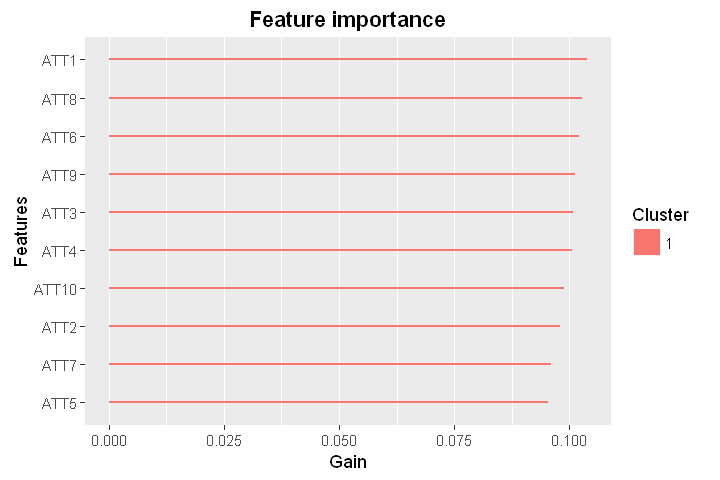

In [93]:
xgb.plot.importance(feature.importance)

## Cross Validate further parameters for XGBoost using GridSearch

In [94]:
xgbGrid <- expand.grid(
    nrounds = c(100, 300, 500),
    max_depth = c(1, 3, 5),
    eta = c(0.001, 0.01, 0.1),
    gamma = c(0, 1),
    colsample_bytree = c(1, 0.9, 0.8),
    min_child_weight = c(1, 2, 3)
)

In [95]:
xgbTrControl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 2,
    verboseIter = FALSE,
    returnData = FALSE,
    allowParallel = TRUE
)

In [96]:
xg_train <- Udf.Utilities.UpSample(train)
xg_train$Result <- as.numeric(xg_train$Result)-1
for(i in c(1:ncol(xg_train))) {
    xg_train[,i] <- as.numeric(xg_train[,i])
}

In [97]:
set.seed(seed)

# This is computationaly expensive - takes about an hour
"
xgbTrain <- train(
    x = as.matrix(xg_train[, ! names(xg_train) %in% c('Result')]), 
    y = xg_train$Result,
    objective = 'multi:softmax',
    trControl = xgbTrControl,
    tuneGrid = xgbGrid,
    method = 'xgbTree',
    num_class = 4,
    eval_metric = 'merror'
)
"

[1] "\nxgbTrain <- train(\n    x = as.matrix(xg_train[, ! names(xg_train) %in% c('Result')]), \n    y = xg_train$Result,\n    objective = 'multi:softmax',\n    trControl = xgbTrControl,\n    tuneGrid = xgbGrid,\n    method = 'xgbTree',\n    num_class = 4,\n    eval_metric = 'merror'\n)\n"

In [98]:
# get the top model and its results
#head(xgbTrain$results[with(xgbTrain$results, order(RMSE)), ], 5)

In [99]:
# Alter the params based on the best performing set of params abvove
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 5, eta = 0.1,
               colsample_bytree = 1, subsample = 0.9,
               gamma = 0, min_child_weight = 1)

In [100]:
bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.555872+0.011707	test-merror:0.652134+0.025207
[20]	train-merror:0.289129+0.007206	test-merror:0.511723+0.025400
[40]	train-merror:0.204115+0.006436	test-merror:0.468037+0.027318
[60]	train-merror:0.150304+0.008822	test-merror:0.448335+0.026242
[80]	train-merror:0.110192+0.005634	test-merror:0.431791+0.024598
[100]	train-merror:0.085363+0.004320	test-merror:0.416671+0.018284
[120]	train-merror:0.066495+0.002619	test-merror:0.409254+0.020660
[140]	train-merror:0.050831+0.001289	test-merror:0.401266+0.018461
[160]	train-merror:0.039257+0.002306	test-merror:0.395275+0.019612
[180]	train-merror:0.029744+0.002702	test-merror:0.389009+0.023091
[200]	train-merror:0.023148+0.001904	test-merror:0.380717+0.021480
[220]	train-merror:0.017472+0.001374	test-merror:0.379010+0.021913
[240]	train-merror:0.013223+0.001038	test-merror:0.377587+0.021500
[260]	train-merror:0.009576+0.001276	test-merror:0.375589+0.021743
[280]	train-merror:0.006817+0.001436	test-merror:0.374163+0.024953
[

In [101]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 489

In [102]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.550228
[1]	xg_train-merror:0.496290
[2]	xg_train-merror:0.461187
[3]	xg_train-merror:0.437785
[4]	xg_train-merror:0.426370
[5]	xg_train-merror:0.413527
[6]	xg_train-merror:0.392123
[7]	xg_train-merror:0.392123
[8]	xg_train-merror:0.376142
[9]	xg_train-merror:0.370719
[10]	xg_train-merror:0.365297
[11]	xg_train-merror:0.353025
[12]	xg_train-merror:0.350742
[13]	xg_train-merror:0.342466
[14]	xg_train-merror:0.340183
[15]	xg_train-merror:0.330194
[16]	xg_train-merror:0.324486
[17]	xg_train-merror:0.321918
[18]	xg_train-merror:0.315068
[19]	xg_train-merror:0.307363
[20]	xg_train-merror:0.299943
[21]	xg_train-merror:0.293950
[22]	xg_train-merror:0.290240
[23]	xg_train-merror:0.282249
[24]	xg_train-merror:0.282249
[25]	xg_train-merror:0.281678
[26]	xg_train-merror:0.278824
[27]	xg_train-merror:0.275114
[28]	xg_train-merror:0.269121
[29]	xg_train-merror:0.267979
[30]	xg_train-merror:0.262842
[31]	xg_train-merror:0.259703
[32]	xg_train-merror:0.255422
[33]	xg_train-merror

In [103]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [104]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 88 78 46 15
         1 92 88 61 14
         2 29 29 30  6
         3  5  9 10  0

Overall Statistics
                                        
               Accuracy : 0.343         
                 95% CI : (0.305, 0.383)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.764989      
                                        
                  Kappa : 0.034         
 Mcnemar's Test P-Value : 0.000653      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.411    0.431    0.204   0.0000
Specificity             0.640    0.578    0.859   0.9575
Pos Pred Value          0.388    0.345    0.319   0.0000
Neg Pred Value          0.662    0.664    0.769   0.9392
Prevalence              0.357    0.340    0.245   0.0583
Detection Rate          0.147    0.147    0.050   0.0000
Detection Prevalence    0.378    0.425    0.157   0.0400
Balan

### Log Transform, scale and centre all features

In [152]:
xg_train <- Udf.Utilities.UpSample(train)
xg_test <- test

In [153]:
# set the Result to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [154]:
xg_train$Result <- as.numeric(xg_train$Result)-1
for(i in c(1:ncol(xg_train))) {
    xg_train[,i] <- as.numeric(log(xg_train[,i]))    
    xg_train[,i] <- scale(xg_train[,i], scale=TRUE, center=TRUE)
}

xg_train$Result <- xg_train.y

In [155]:
for(i in c(1:ncol(xg_test))) {
    xg_test[,i] <- as.numeric(log(xg_test[,i]))    
    xg_test[,i] <- scale(xg_test[,i], scale=TRUE, center=TRUE)
}

xg_test$Result <- xg_test.y

In [156]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [157]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [135]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[0]	xg_train-merror:0.745434
[1]	xg_train-merror:0.754566
[2]	xg_train-merror:0.750856
[3]	xg_train-merror:0.752568
[4]	xg_train-merror:0.751142
[5]	xg_train-merror:0.752568
[6]	xg_train-merror:0.752568
[7]	xg_train-merror:0.752568
[8]	xg_train-merror:0.752568
[9]	xg_train-merror:0.752568
[10]	xg_train-merror:0.751427
[11]	xg_train-merror:0.751427
[12]	xg_train-merror:0.750856
[13]	xg_train-merror:0.751712
[14]	xg_train-merror:0.751712
[15]	xg_train-merror:0.752283
[16]	xg_train-merror:0.752568
[17]	xg_train-merror:0.751712
[18]	xg_train-merror:0.752568
[19]	xg_train-merror:0.752568
[20]	xg_train-merror:0.750571
[21]	xg_train-merror:0.750571
[22]	xg_train-merror:0.750571
[23]	xg_train-merror:0.750285
[24]	xg_train-merror:0.750000
[25]	xg_train-merror:0.749715
[26]	xg_train-merror:0.749715
[27]	xg_train-merror:0.749715
[28]	xg_train-merror:0.749715
[29]	xg_train-merror:0.749715
[30]	xg_train-merror:0.749429
[31]	xg_train-merror:0.749715
[32]	xg_train-merror:0.749715
[33]	xg_train-merror

[1] 415

In [158]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.745434
[1]	xg_train-merror:0.754566
[2]	xg_train-merror:0.750856
[3]	xg_train-merror:0.752568
[4]	xg_train-merror:0.751142
[5]	xg_train-merror:0.752568
[6]	xg_train-merror:0.752568
[7]	xg_train-merror:0.752568
[8]	xg_train-merror:0.752568
[9]	xg_train-merror:0.752568
[10]	xg_train-merror:0.751427
[11]	xg_train-merror:0.751427
[12]	xg_train-merror:0.750856
[13]	xg_train-merror:0.751712
[14]	xg_train-merror:0.751712
[15]	xg_train-merror:0.752283
[16]	xg_train-merror:0.752568
[17]	xg_train-merror:0.751712
[18]	xg_train-merror:0.752568
[19]	xg_train-merror:0.752568
[20]	xg_train-merror:0.750571
[21]	xg_train-merror:0.750571
[22]	xg_train-merror:0.750571
[23]	xg_train-merror:0.750285
[24]	xg_train-merror:0.750000
[25]	xg_train-merror:0.749715
[26]	xg_train-merror:0.749715
[27]	xg_train-merror:0.749715
[28]	xg_train-merror:0.749715
[29]	xg_train-merror:0.749715
[30]	xg_train-merror:0.749429
[31]	xg_train-merror:0.749715
[32]	xg_train-merror:0.749715
[33]	xg_train-merror

In [159]:
# generate predictions from model
pred_xgb_std <- predict(bst, xg_test);

In [160]:
confusionMatrix(pred_xgb_std, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 87 74 52 12
         1 81 95 68 16
         2 35 30 22  6
         3 11  5  5  1

Overall Statistics
                                        
               Accuracy : 0.342         
                 95% CI : (0.304, 0.381)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.790517      
                                        
                  Kappa : 0.03          
 Mcnemar's Test P-Value : 0.000466      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.407    0.466   0.1497  0.02857
Specificity             0.642    0.583   0.8433  0.96283
Pos Pred Value          0.387    0.365   0.2366  0.04545
Neg Pred Value          0.661    0.679   0.7535  0.94118
Prevalence              0.357    0.340   0.2450  0.05833
Detection Rate          0.145    0.158   0.0367  0.00167
Detection Prevalence    0.375    0.433   0.1550  0.03667
Balan

# 4. Random Forest

In [51]:
rforest_train <- Udf.Utilities.UpSample(train)

mtry = 3  OOB error = 34.05% 
Searching left ...
mtry = 2 	OOB error = 33.9% 
0.004191 0.00001 
Searching right ...
mtry = 4 	OOB error = 33.85% 
0.001684 0.00001 
mtry = 6 	OOB error = 34.5% 
-0.01939 0.00001 


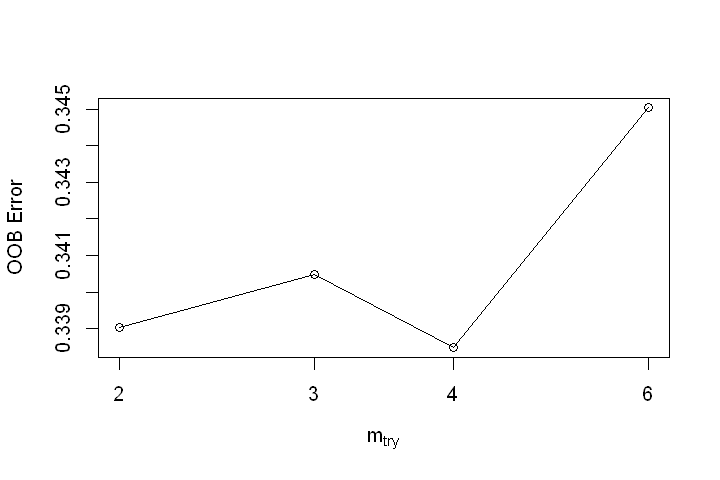

In [52]:
# cross validate the mtry parameter
bestmtry <- tuneRF(rforest_train[,1:10], rforest_train$Result, stepFactor=1.5, improve=1e-5, ntree=10000)

In [53]:
rforest <- randomForest(Result ~., data = rforest_train, ntree=10000, mtry=2)
rforest


Call:
 randomForest(formula = Result ~ ., data = rforest_train, ntree = 10000,      mtry = 2) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 34.05%
Confusion matrix:
    0   1   2   3 class.error
0 393 400  75   8      0.5514
1 394 387  84  11      0.5582
2  94 123 655   4      0.2523
3   0   0   0 876      0.0000

In [54]:
pred <- predict(rforest, test)

In [55]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 96 92 70 17
         1 92 90 64 18
         2 24 22 13  0
         3  2  0  0  0

Overall Statistics
                                        
               Accuracy : 0.332         
                 95% CI : (0.294, 0.371)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.907         
                                        
                  Kappa : -0.009        
 Mcnemar's Test P-Value : NA            

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.449    0.441   0.0884  0.00000
Specificity             0.536    0.561   0.8985  0.99646
Pos Pred Value          0.349    0.341   0.2203  0.00000
Neg Pred Value          0.637    0.661   0.7523  0.94147
Prevalence              0.357    0.340   0.2450  0.05833
Detection Rate          0.160    0.150   0.0217  0.00000
Detection Prevalence    0.458    0.440   0.0983  0.00333
Balan

In [56]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT1             252.9
ATT2             265.0
ATT3             251.3
ATT4             256.0
ATT5             251.3
ATT6             258.4
ATT7             255.3
ATT8             262.7
ATT9             259.6
ATT10            264.3


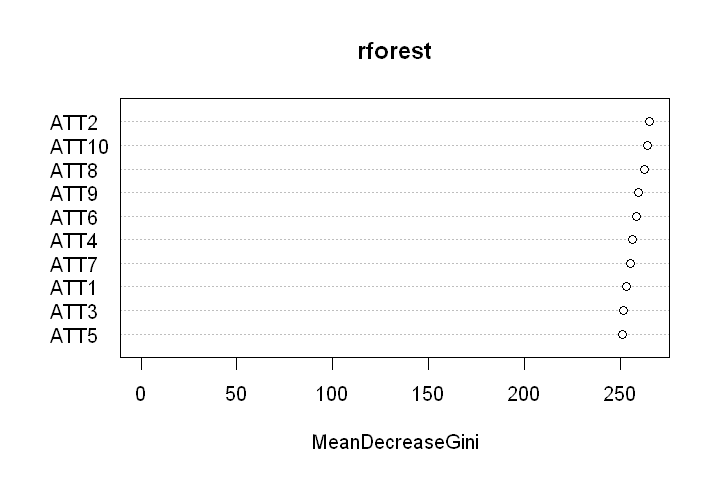

In [57]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
varImpPlot(rforest)

## Cross Validation for Random Forest feature selection 

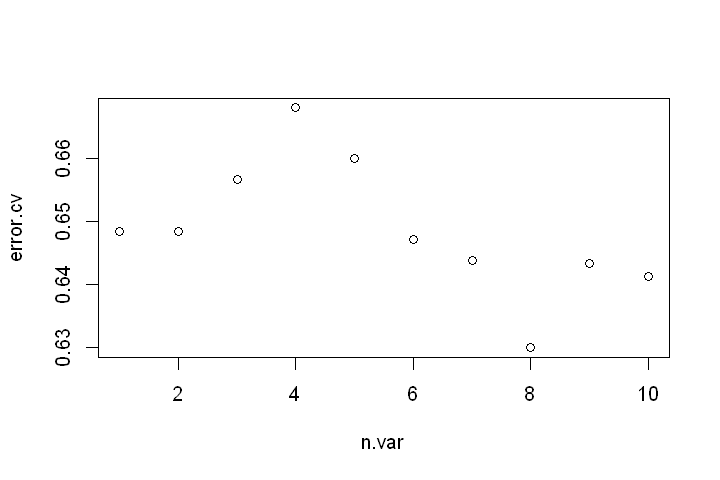

In [58]:
x <- train
x$Result <- NULL
y <- train$Result

rf.cv <- rfcv(x, y, cv.fold=10, step=0.9)

with(rf.cv, plot(n.var, error.cv))

Ok, this is telling us that a 7 feature model is performing the best. Let's try retrain the model without the lowest importance features and rerun the predictions

In [59]:
rforest <- randomForest(Result ~ . - ATT5, data = rforest_train, mtry=2, ntree=10000)

In [60]:
rforest


Call:
 randomForest(formula = Result ~ . - ATT5, data = rforest_train,      mtry = 2, ntree = 10000) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 34.13%
Confusion matrix:
    0   1   2   3 class.error
0 389 395  80  12      0.5559
1 392 375 103   6      0.5719
2  88 117 668   3      0.2374
3   0   0   0 876      0.0000

In [61]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT1             278.5
ATT2             293.5
ATT3             277.2
ATT4             281.4
ATT6             284.4
ATT7             280.8
ATT8             290.6
ATT9             284.3
ATT10            292.7


In [62]:
pred_rforest <- predict(rforest, test)

In [63]:
confusionMatrix(pred_rforest, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 95 86 67 17
         1 88 94 63 17
         2 27 23 15  1
         3  4  1  2  0

Overall Statistics
                                        
               Accuracy : 0.34          
                 95% CI : (0.302, 0.379)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.814         
                                        
                  Kappa : 0.01          
 Mcnemar's Test P-Value : 0.000000000102

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.444    0.461    0.102   0.0000
Specificity             0.560    0.576    0.887   0.9876
Pos Pred Value          0.358    0.359    0.227   0.0000
Neg Pred Value          0.645    0.675    0.753   0.9410
Prevalence              0.357    0.340    0.245   0.0583
Detection Rate          0.158    0.157    0.025   0.0000
Detection Prevalence    0.442    0.437    0.110   0.0117
Balan

---
# Ensemble the Predictions

In [161]:
# create a dataframe to store each of the predictions from each of the models we want to ensemble
preds_df <- data.frame(matrix(ncol = 0, nrow =600))

In [162]:
preds_df$pred_xgb <- pred_xgb
preds_df$pred_xgb_std <- pred_xgb_std
preds_df$pred_rforest <- pred_rforest

In [166]:
head(preds_df)

,pred_xgb,pred_xgb_std,pred_rforest
1,3,3,1
2,0,0,1
3,1,1,0
4,2,2,0
5,0,0,1
6,1,1,0


In [164]:
table(preds_df$pred_xgb)


  0   1   2   3 
233 250  96  21 

In [210]:
preds_df <- Udf.Utilities.MajorityVotePredictions(preds_df)

In [205]:
head(preds_df)

,pred_xgb,pred_xgb_std,pred_rforest,majority_pred
1,3,3,1,3
2,0,0,1,0
3,1,1,0,1
4,2,2,0,2
5,0,0,1,0
6,1,1,0,1


In [208]:
confusionMatrix(actual, preds_df$majority_pred)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 86 80 40  8
         1 74 95 30  5
         2 51 68 21  7
         3  8 19  7  1

Overall Statistics
                                        
               Accuracy : 0.338         
                 95% CI : (0.301, 0.378)
    No Information Rate : 0.437         
    P-Value [Acc > NIR] : 1.000000      
                                        
                  Kappa : 0.026         
 Mcnemar's Test P-Value : 0.000429      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.393    0.363    0.214  0.04762
Specificity             0.664    0.678    0.749  0.94128
Pos Pred Value          0.402    0.466    0.143  0.02857
Neg Pred Value          0.655    0.578    0.830  0.96460
Prevalence              0.365    0.437    0.163  0.03500
Detection Rate          0.143    0.158    0.035  0.00167
Detection Prevalence    0.357    0.340    0.245  0.05833
Balan